In [77]:
import sys
sys.path.append('../../src')
import pandas
import random
import math
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.model.constraints.demand import constraint_demand2
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.plot.plot_results import  CostX, CostY
from energiapy.model.solve import solve
from pyomo.environ import Param
from energiapy.utils.scale_utils import scale_pyomo_set

In [78]:
_time_intervals = 30  # Number of time intervals in a planning horizon    (L_chi)
_coms = 1
_exec_scenarios = 12  # Number of execution scenarios                     (chi)

M = 1e3  # Big M

init = [1]

loc1_varying_factor = pandas.DataFrame(data={'com1_pur': [1.0, 0.6, 0.25, 0.13, 0.17, 0.57, 0.72, 0.49, 0.21, 0.3, 0.59, 0.69]})

loc6_varying_factor = pandas.DataFrame(data={'com1_pur': [1.0, 0.36, 0.68, 0.28, 0.41, 0.15, 0.15, 0.68, 0.73, 0.54, 0.19, 0.13]})

# Define temporal scales
scales = TemporalScale(discretization_list=[1, _exec_scenarios, _time_intervals])

demand_factor = [1]*_exec_scenarios

In [79]:
# ======================================================================================================================
# Declare resources/commodities
# ======================================================================================================================

com1_pur = Resource(name='com1_pur', cons_max=200, block={'imp': 1, 'urg': 1}, price=0.00,
                    label='Commodity 1 consumed from outside the system', varying=[VaryingResource.DETERMINISTIC_AVAILABILITY])

com1_in = Resource(name='com1_in', label='Commodity 1 received')

com1_stored10 = Resource(name='com1_stored10', store_max=10, label='Commodity 1 in storage10')
com1_stored20 = Resource(name='com1_stored20', store_max=20, label='Commodity 1 in storage20')
com1_stored50 = Resource(name='com1_stored50', store_max=50, label='Commodity 1 in storage50')

com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')

com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')

com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True, label='Commodity 1 sold to outside the system')

In [80]:
# ======================================================================================================================
# Declare processes/storage capacities
# ======================================================================================================================
com1_procure = Process(name='procure com1', prod_max=M, conversion={com1_pur: -1, com1_in: 1}, capex=0.001, vopex=0.001, fopex=0.001,
                  label='Procure com1')
com1_sell = Process(name='sell com1', prod_max=M, conversion={com1_out: -1, com1_sold: 1}, capex=0.001, vopex=0.001, fopex=0.001,
                  label='Sell com1')

com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=M, conversion={com1_loc1_out:-1, com1_in:1}, capex=0.001, vopex=0.001, fopex=0.001,
                            label='Commodity 1 received from location 1')
com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=M, conversion={com1_loc2_out:-1, com1_in:1}, capex=0.001, vopex=0.001, fopex=0.001,
                            label='Commodity 1 received from location 2')
com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=M, conversion={com1_loc3_out:-1, com1_in:1}, capex=0.001, vopex=0.001, fopex=0.001,
                            label='Commodity 1 received from location 3')
com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=M, conversion={com1_loc4_out:-1, com1_in:1}, capex=0.001, vopex=0.001, fopex=0.001,
                            label='Commodity 1 received from location 4')
com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=M, conversion={com1_loc6_out:-1, com1_in:1}, capex=0.001, vopex=0.001, fopex=0.001,
                            label='Commodity 1 received from location 6')
com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=M, conversion={com1_loc7_out:-1, com1_in:1}, capex=0.001, vopex=0.001, fopex=0.001,
                            label='Commodity 1 received from location 7')

com1_process = Process(name='com1_process', prod_max=M, conversion={com1_in:-1, com1_out:1}, capex=0.001, vopex=0.001, fopex=0.001,
                            label='Process the commodity through the location')

com1_store10 = Process(name='com1_store10', conversion={com1_in:-1, com1_stored10:1}, store_max=10/_coms, prod_max=M, capex=10, vopex=1,
                  label="Storage capacity of 10 units")
com1_discharge10 = Process(name='com1_discharge10', conversion={com1_stored10:-1, com1_out:1}, vopex=1,
                                 label='Discharge process from storage')

com1_store20 = Process(name='com1_store20', conversion={com1_in:-1, com1_stored20:1}, store_max=20/_coms, prod_max=M, capex=20, vopex=2,
                  label="Storage capacity of 20 units")
com1_discharge20 = Process(name='com1_discharge20', conversion={com1_stored20:-1, com1_out:1}, vopex=2,
                                 label='Discharge process from storage')

com1_store50 = Process(name='com1_store50', conversion={com1_in:-1, com1_stored50:1}, store_max=50/_coms, prod_max=M, capex=50, vopex=5,
                  label="Storage capacity of 50 units")
com1_discharge50 = Process(name='com1_discharge50', conversion={com1_stored50:-1, com1_out:1}, vopex=5,
                                 label='Discharge process from storage')

com1_loc1_send = Process(name='com1_loc1_send', prod_max=M, conversion={com1_out:-1, com1_loc1_out:1}, capex=0.001, vopex=0.001, fopex=0.001,
                            label='Send commodity one from location 1')
com1_loc2_send = Process(name='com1_loc2_send', prod_max=M, conversion={com1_out:-1, com1_loc2_out:1}, capex=0.001, vopex=0.001, fopex=0.001,
                            label='Send commodity one from location 1')
com1_loc3_send = Process(name='com1_loc3_send', prod_max=M, conversion={com1_out:-1, com1_loc3_out:1}, capex=0.001, vopex=0.001, fopex=0.001,
                            label='Send commodity one from location 1')
com1_loc4_send = Process(name='com1_loc4_send', prod_max=M, conversion={com1_out:-1, com1_loc4_out:1}, capex=0.001, vopex=0.001, fopex=0.001,
                            label='Send commodity one from location 1')
com1_loc6_send = Process(name='com1_loc6_send', prod_max=M, conversion={com1_out:-1, com1_loc6_out:1}, capex=0.001, vopex=0.001, fopex=0.001,
                            label='Send commodity one from location 1')
com1_loc7_send = Process(name='com1_loc7_send', prod_max=M, conversion={com1_out:-1, com1_loc7_out:1}, capex=0.001, vopex=0.001, fopex=0.001,
                            label='Send commodity one from location 1')


In [81]:
# ======================================================================================================================
# Declare locations/warehouses
# ======================================================================================================================
loc1 = Location(name='loc1', processes={com1_procure, com1_process, com1_store20, com1_discharge20, com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1, availability_factor={com1_pur: loc1_varying_factor[['com1_pur']]})

loc2 = Location(name='loc2', processes={com1_receive_loc1, com1_process, com1_store20, com1_discharge20, com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc3 = Location(name='loc3', processes={com1_receive_loc1, com1_process, com1_store20, com1_discharge20, com1_loc3_send}, label="Location 3", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_process, com1_store50, com1_discharge50, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc5 = Location(name='loc5', processes={com1_receive_loc2, com1_receive_loc4, com1_receive_loc7, com1_process, com1_store50, com1_discharge50, com1_sell,}, label="Location 5", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc6 = Location(name='loc6', processes={com1_procure, com1_process, com1_store10, com1_discharge10, com1_loc6_send}, label="Location 6", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1, availability_factor={com1_pur: loc6_varying_factor[['com1_pur']]})

loc7 = Location(name='loc7', processes={com1_receive_loc4, com1_process, com1_store20, com1_discharge20, com1_loc7_send}, label="Location 7", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

In [82]:
# ======================================================================================================================
# Declare transport/trucks
# ======================================================================================================================
truck20_34 = Transport(name='truck20_34', resources={com1_loc3_out}, trans_max=20, label='Truck with maximum capacity of 20 units', capex=2, vopex=0.2)
truck30_13 = Transport(name='truck30_13', resources={com1_loc1_out}, trans_max=30, label='Truck with maximum capacity of 30 units', capex=3, vopex=0.2)
truck30_25 = Transport(name='truck30_25', resources={com1_loc2_out}, trans_max=30, label='Truck with maximum capacity of 30 units', capex=3, vopex=0.2)
truck40_47 = Transport(name='truck40_47', resources={com1_loc4_out}, trans_max=40, label='Truck with maximum capacity of 40 units', capex=4, vopex=0.2)
truck40_75 = Transport(name='truck40_75', resources={com1_loc7_out}, trans_max=40, label='Truck with maximum capacity of 40 units', capex=4, vopex=0.2)
truck50_12 = Transport(name='truck50_12', resources={com1_loc1_out}, trans_max=50, label='Truck with maximum capacity of 50 units', capex=5, vopex=0.2)
truck50_24 = Transport(name='truck50_24', resources={com1_loc2_out}, trans_max=50, label='Truck with maximum capacity of 50 units', capex=5, vopex=0.2)
truck50_64 = Transport(name='truck50_64', resources={com1_loc6_out}, trans_max=50, label='Truck with maximum capacity of 50 units', capex=5, vopex=0.2)
truck100_45 = Transport(name='truck100_45', resources={com1_loc4_out}, trans_max=100, label='Truck with maximum capacity of 100 units', capex=10, vopex=0.2)

In [83]:
# ======================================================================================================================
# Declare network
# ======================================================================================================================
transport_matrix = [
    [[], [truck50_12], [truck30_13], [], [], [], []],  # source: location 1
    [[], [], [], [truck50_24], [truck30_25], [], []],  # source: location 2
    [[], [], [], [truck20_34], [], [], []],  # source: location 3
    [[], [], [], [], [truck100_45], [], [truck40_47]],  # source: location 4
    [[], [], [], [], [], [], []],  # source: location 5
    [[], [], [], [truck50_64], [], [], []],  # source: location 6
    [[], [], [], [], [truck40_75], [], []]  # source: location 7
]

distance_matrix = [
    [0, 55, 196, M, M, M, M],
    [55, 0, M, 163, 112, M, 134],
    [196, M, 0, 63, M, M, M],
    [M, 163, 63, 0, 95, 117, 88],
    [M, 112, M, 95, 0, M, 134],
    [M, M, M, 117, M, 0, M],
    [M, 134, M, 88, 134, M, 0]
]

locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

sources = locset
sinks = locset

network = Network(name='Network', scales= scales, source_locations=sources, sink_locations=sinks, transport_matrix=transport_matrix, distance_matrix=distance_matrix)

In [84]:
demand_dict = {i: {com1_sold: 100} if i == loc5 else {com1_sold: 0} for i in locset}
demand_penalty_dict = {i: {com1_sold: 5000} if i == loc5 else {com1_sold: 0} for i in locset}
min_demand_satisfaction = 0.20
min_demand_dict = {i: {com1_sold: min_demand_satisfaction*100} if i == loc5 else {com1_sold: 0} for i in locset}

scenario_disruption = Scenario(name='scenario_disruption', scales=scales, scheduling_scale_level=2, network_scale_level=0, purchase_scale_level=2, availability_scale_level=1, demand_scale_level=2, capacity_scale_level=1,
                    network=network, demand=demand_dict, demand_penalty=demand_penalty_dict, label='scenario_disruption')

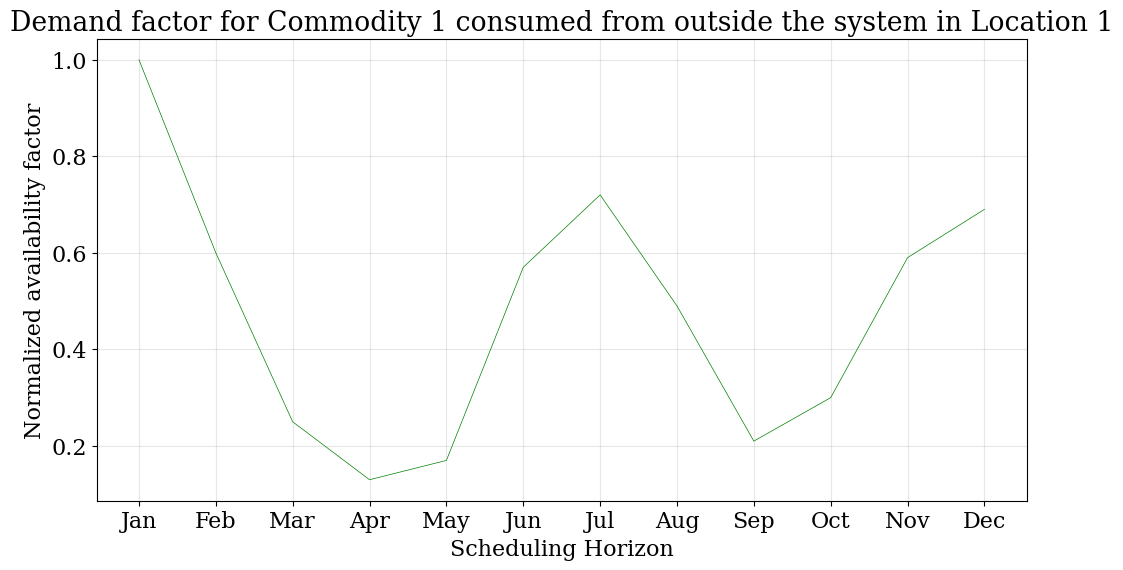

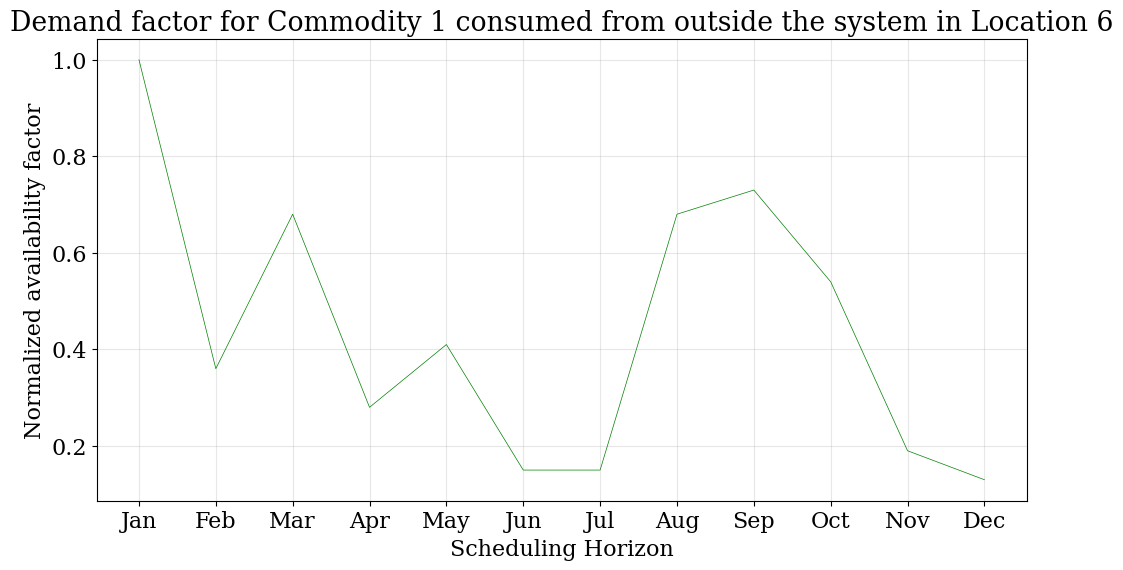

In [85]:
plot_scenario.availability_factor(scenario=scenario_disruption, resource=com1_pur, location=loc1, color='green')
plot_scenario.availability_factor(scenario=scenario_disruption, resource=com1_pur, location=loc6, color='green')

In [86]:
problem_mincost = formulate(scenario=scenario_disruption,
                            constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.NETWORK, Constraints.RESOURCE_BALANCE,
                                         Constraints.INVENTORY, Constraints.PRODUCTION,  Constraints.DEMAND},
                            demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
constraint resource export
constraint transport export
constraint export
constraint transport capacity UB
constraint transport capacity LB
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand penalty
objective cost w demand penalty


In [87]:
# min_demand = min_demand_dict
# if isinstance(min_demand, dict):
#     if isinstance(list(min_demand.keys())[0], Location):
#         try:
#             min_demand = {i.name: {
#                 j.name: min_demand[i][j] for j in min_demand[i].keys()} for i in min_demand.keys()}
#         except:
#             pass
# 
# problem_mincost.del_component(constraint_demand2)
# problem_mincost.constraint_demand2 = constraint_demand2(instance=problem_mincost, demand=min_demand, demand_factor=scenario_disruption.demand_factor, demand_scale_level=scenario_disruption.demand_scale_level, scheduling_scale_level=scenario_disruption.scheduling_scale_level, cluster_wt=None, loc_res_dict= None, sign='geq')

In [88]:
results_mincost = solve(scenario=scenario_disruption, instance=problem_mincost, solver='gurobi', name='MILP')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 415431 rows, 1346975 columns and 674281 nonzeros
Model fingerprint: 0xecffe583
Variable types: 1346366 continuous, 609 integer (609 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e+00, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+03]
Found heuristic solution: objective 1.800000e+08
Presolve removed 394705 rows and 1334128 columns
Presolve time: 0.67s
Presolved: 20726 rows, 12847 columns, 57286 nonzeros
Variable types: 12847 continuous, 0 integer (0 binary)

Root relaxation: objective 7.133724e+06, 16320 iterations, 1.31 seconds (1.21 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf 

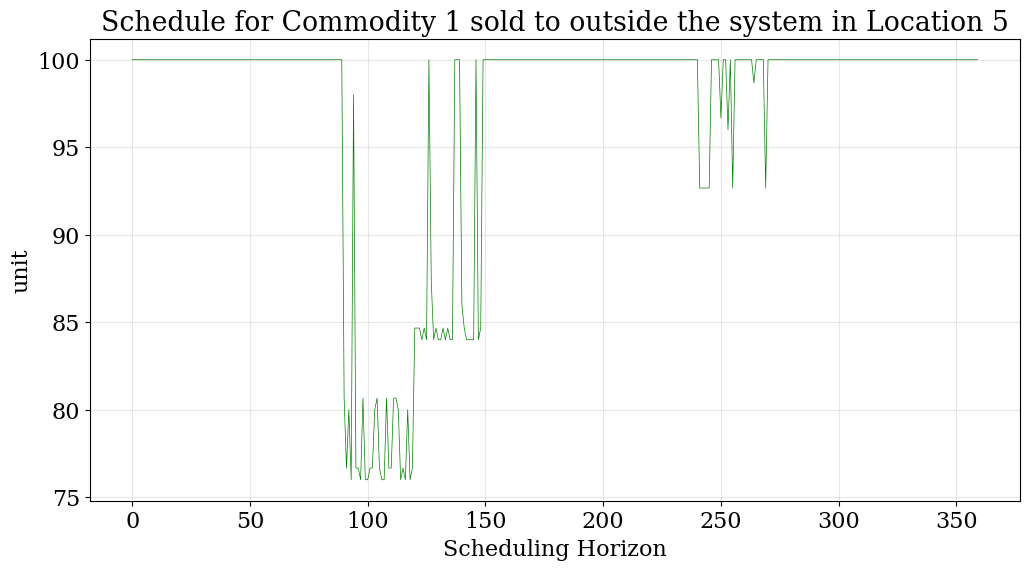

In [89]:
plot_results.schedule(results=results_mincost, y_axis='S', component='com1_sold', location='loc5', color='green')

In [90]:
min(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')

76.0

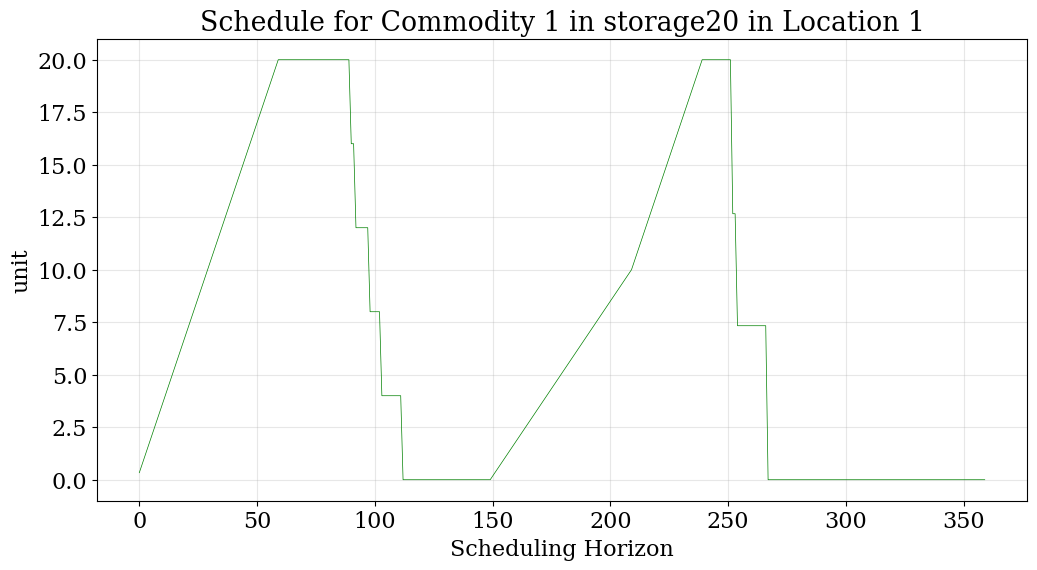

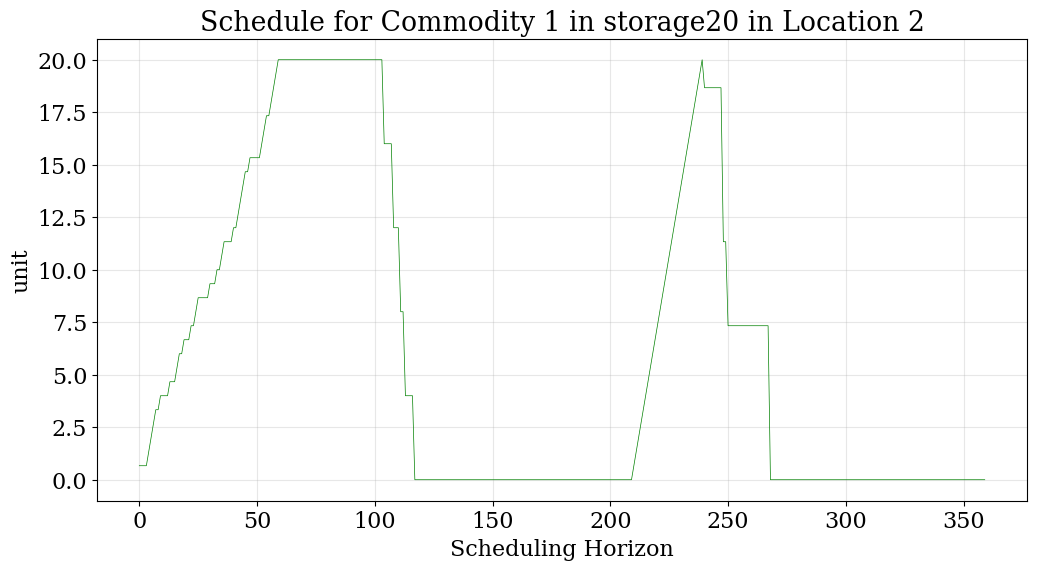

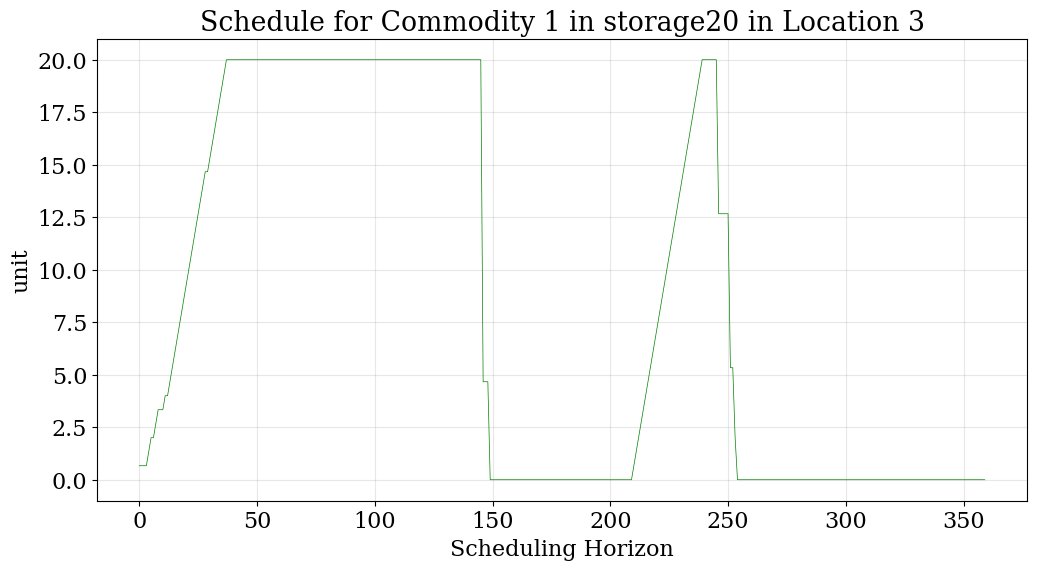

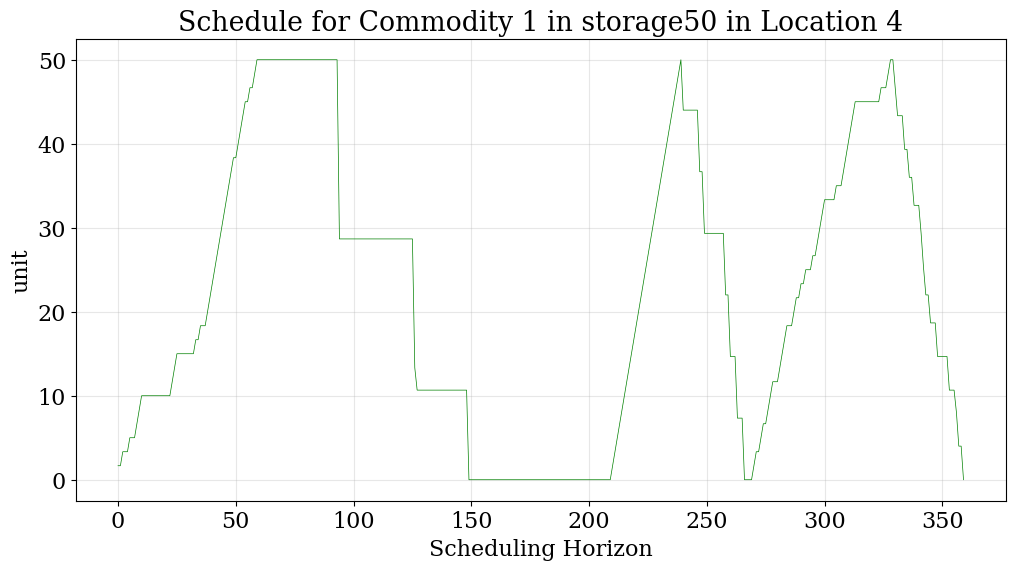

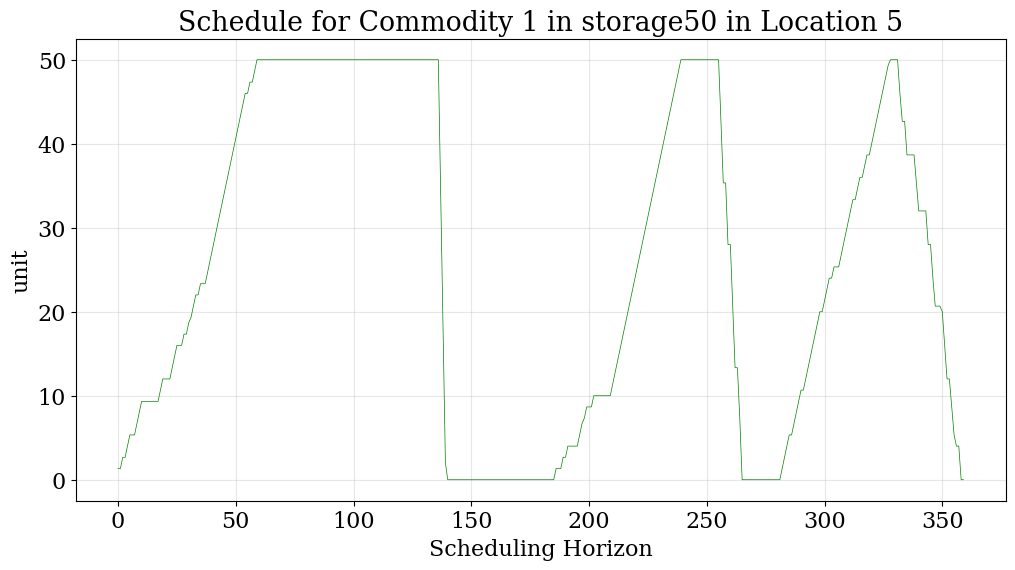

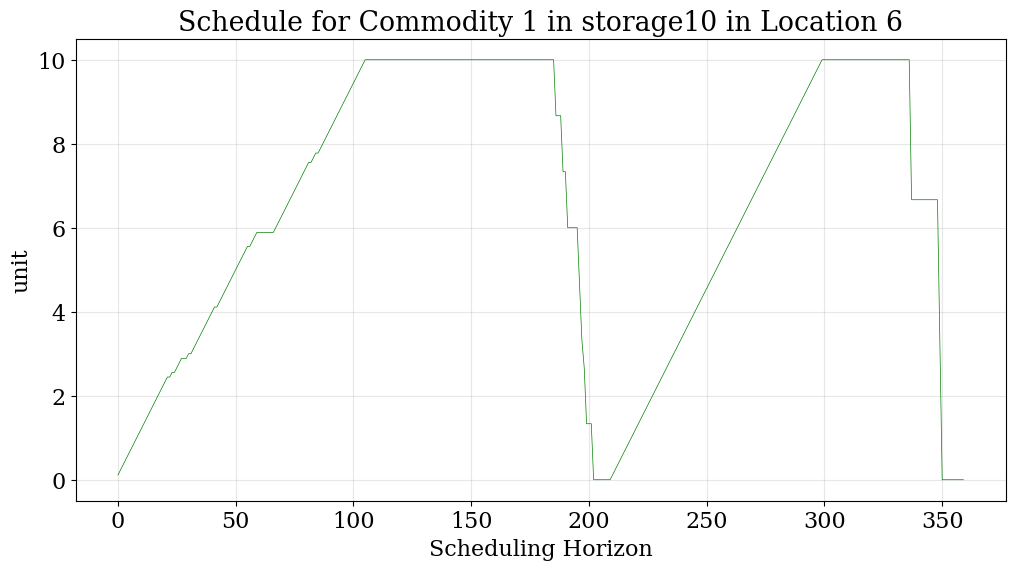

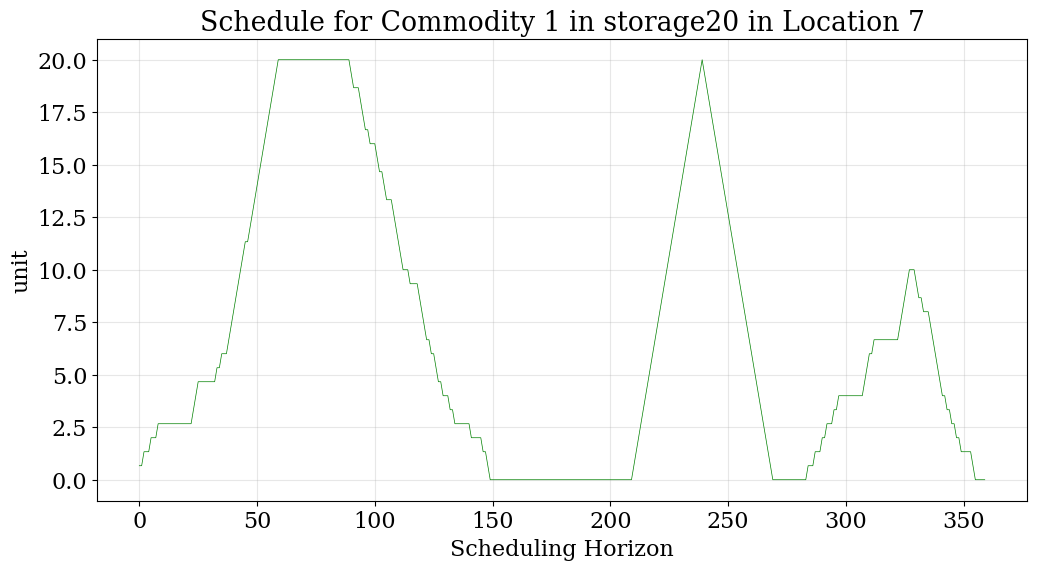

In [91]:
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored20', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored20', location='loc2', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored20', location='loc3', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored50', location='loc4', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored50', location='loc5', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored10', location='loc6', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored20', location='loc7', color='green')

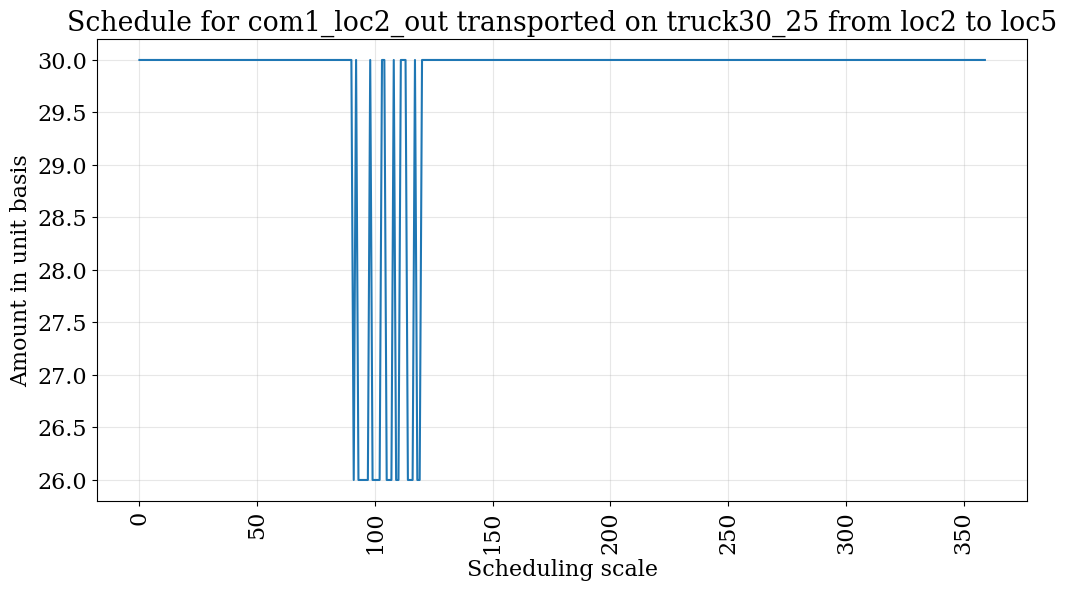

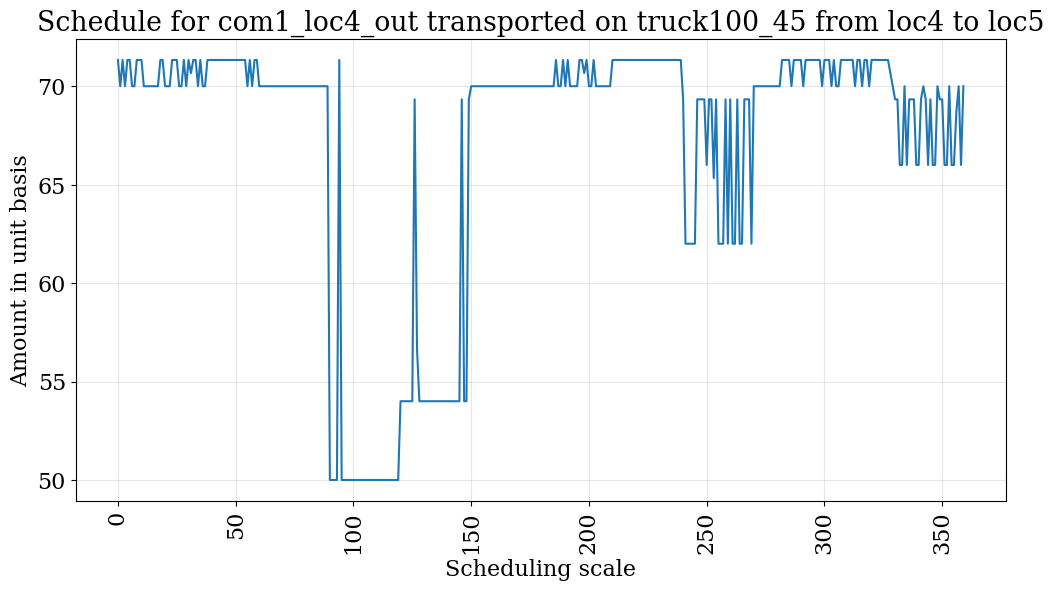

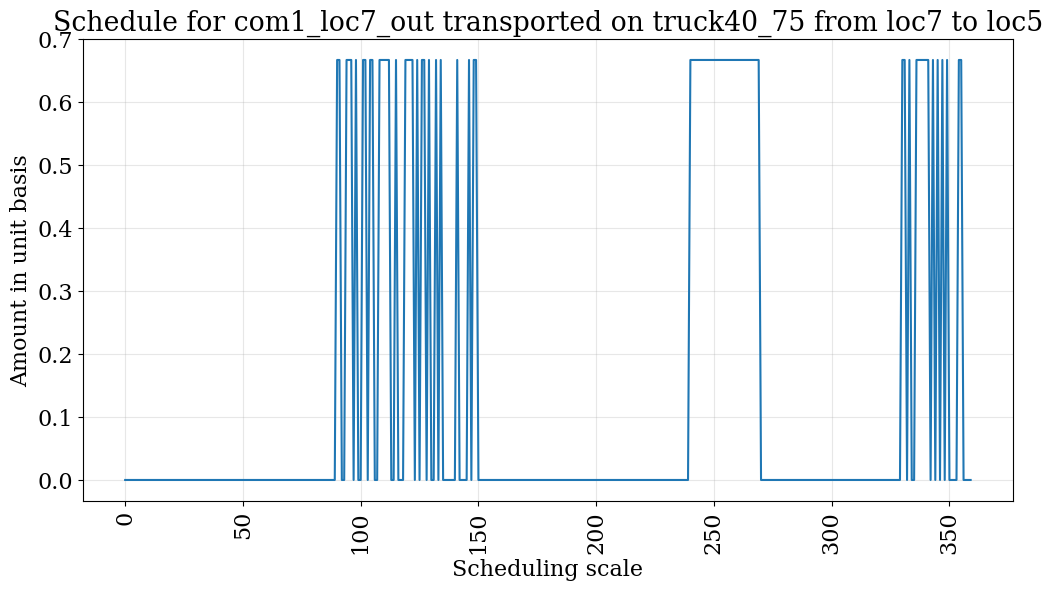

In [92]:
plot_results.transport(results=results_mincost, source='loc2', sink='loc5', transport='truck30_25', resource='com1_loc2_out')
plot_results.transport(results=results_mincost, source='loc4', sink='loc5', transport='truck100_45', resource='com1_loc4_out')
plot_results.transport(results=results_mincost, source='loc7', sink='loc5', transport='truck40_75', resource='com1_loc7_out')

In [93]:
print([(key, value) for key, value in results_mincost.output['X_F'].items() if value==1])

[(('loc1', 'loc2', 'truck50_12', 0), 1.0), (('loc1', 'loc3', 'truck30_13', 0), 1.0), (('loc2', 'loc4', 'truck50_24', 0), 1.0), (('loc2', 'loc5', 'truck30_25', 0), 1.0), (('loc3', 'loc4', 'truck20_34', 0), 1.0), (('loc4', 'loc5', 'truck100_45', 0), 1.0), (('loc4', 'loc7', 'truck40_47', 0), 1.0), (('loc6', 'loc4', 'truck50_64', 0), 1.0), (('loc7', 'loc5', 'truck40_75', 0), 1.0)]


In [94]:
problem_mincost.Capex_network.pprint()
problem_mincost.Fopex_network.pprint()
problem_mincost.Vopex_network.pprint()

Capex_network : Capex at network scale
    Size=1, Index=scales_network
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
      0 :     0 : 198.88538888888863 :  None : False : False : NonNegativeReals
Fopex_network : Fixed Opex at network scale
    Size=1, Index=scales_network
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
      0 :     0 : 1.1076111111111113 :  None : False : False : NonNegativeReals
Vopex_network : Variable Opex at network scale
    Size=1, Index=scales_network
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
      0 :     0 : 4059.3199999999974 :  None : False : False : NonNegativeReals


In [95]:
problem_mincost.Capex_transport_network.pprint()
problem_mincost.Fopex_transport_network.pprint()
problem_mincost.Vopex_transport_network.pprint()

Capex_transport_network : overall capex for transport at the network level
    Size=1, Index=scales_network
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
      0 :     0 : 152018.66666666666 :  None : False : False : NonNegativeReals
Fopex_transport_network : overall fopex for transport at the network level
    Size=1, Index=scales_network
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      0 :     0 :   0.0 :  None : False : False : NonNegativeReals
Vopex_transport_network : overall vopex for transport at the network level
    Size=1, Index=scales_network
    Key : Lower : Value     : Upper : Fixed : Stale : Domain
      0 :     0 : 1577446.0 :  None : False : False : NonNegativeReals


In [96]:
# import matplotlib.pyplot as plt
# from matplotlib import rc
# 
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
# rc('text', usetex=False)
# 
# fig, ax = plt.subplots()
# 
# # Plot data from the first dataset
# ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'), label='Location 4', color='blue')
# 
# # ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'), label='Location 6', color='green')
# # 
# # ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'), label='Location 7', color='red')
# 
# # Plot data from the second dataset
# # ax.plot(range(len(scenario_disruption.availability_factor['loc6']['com1_pur'])), list(scenario_disruption.availability_factor['loc6']['com1_pur'].values()), label='Location 6', color='red', marker='x')
# 
# # Customize the plot
# ax.set_xlabel('Time Horizon')
# ax.set_ylabel('Inventory level')
# ax.set_title('Inventory levels for Commodity 1')
# ax.legend()
# ax.plot(linewidth=0.5)
# plt.grid(alpha=0.3)
# plt.rcdefaults()
# # Show the plot
# plt.show()

# Pareto Fronts

In [97]:
levels = [76, 77, 78, 79, 80, 81, 82, 83]

In [98]:
# problem_mincost_1 = formulate(scenario=scenario_disruption, constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE, Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND}, demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)
# 
# min_demand_satisfaction_1 = levels[1]
# min_demand_dict_1 = {i: {com1_sold: min_demand_satisfaction_1} if i == loc5 else {com1_sold: 0} for i in locset}
# 
# min_demand_1 = min_demand_dict_1
# if isinstance(min_demand_1, dict):
#     if isinstance(list(min_demand_1.keys())[0], Location):
#         try:
#             min_demand_1 = {i.name: {
#                 j.name: min_demand_1[i][j] for j in min_demand_1[i].keys()} for i in min_demand_1.keys()}
#         except:
#             pass
# 
# problem_mincost_1.del_component(constraint_demand2)
# problem_mincost_1.constraint_demand2 = constraint_demand2(instance=problem_mincost_1, demand=min_demand_1, demand_factor=scenario_disruption.demand_factor, demand_scale_level=scenario_disruption.demand_scale_level, scheduling_scale_level=scenario_disruption.scheduling_scale_level, cluster_wt=None, loc_res_dict= None, sign='geq')
# 
# results_mincost_1 = solve(scenario=scenario_disruption, instance=problem_mincost_1, solver='gurobi', name='MILP')

In [99]:
# plot_results.schedule(results=results_mincost_1, y_axis='S', component='com1_sold', location='loc5', color='green')

In [100]:
# min(value for key, value in results_mincost_1.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')

In [101]:
# problem_mincost_1.Capex_network.pprint()
# problem_mincost_1.Fopex_network.pprint()
# problem_mincost_1.Vopex_network.pprint()
# problem_mincost_1.Capex_transport_network.pprint()
# problem_mincost_1.Fopex_transport_network.pprint()
# problem_mincost_1.Vopex_transport_network.pprint()

In [102]:
# problem_mincost_2 = formulate(scenario=scenario_disruption, constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE, Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND}, demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)
# 
# min_demand_satisfaction_2 = levels[2]
# min_demand_dict_2 = {i: {com1_sold: min_demand_satisfaction_2} if i == loc5 else {com1_sold: 0} for i in locset}
# 
# min_demand_2 = min_demand_dict_2
# if isinstance(min_demand_2, dict):
#     if isinstance(list(min_demand_2.keys())[0], Location):
#         try:
#             min_demand_2 = {i.name: {
#                 j.name: min_demand_2[i][j] for j in min_demand_2[i].keys()} for i in min_demand_2.keys()}
#         except:
#             pass
# 
# problem_mincost_2.del_component(constraint_demand2)
# problem_mincost_2.constraint_demand2 = constraint_demand2(instance=problem_mincost_2, demand=min_demand_2, demand_factor=scenario_disruption.demand_factor, demand_scale_level=scenario_disruption.demand_scale_level, scheduling_scale_level=scenario_disruption.scheduling_scale_level, cluster_wt=None, loc_res_dict= None, sign='geq')
# 
# results_mincost_2 = solve(scenario=scenario_disruption, instance=problem_mincost_2, solver='gurobi', name='MILP')

In [103]:
# plot_results.schedule(results=results_mincost_2, y_axis='S', component='com1_sold', location='loc5', color='green')

In [104]:
# min(value for key, value in results_mincost_2.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')

In [105]:
# problem_mincost_2.Capex_network.pprint()
# problem_mincost_2.Fopex_network.pprint()
# problem_mincost_2.Vopex_network.pprint()
# problem_mincost_2.Capex_transport_network.pprint()
# problem_mincost_2.Fopex_transport_network.pprint()
# problem_mincost_2.Vopex_transport_network.pprint()

In [106]:
# problem_mincost_3 = formulate(scenario=scenario_disruption, constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE, Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND}, demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)
# 
# min_demand_satisfaction_3 = levels[3]
# min_demand_dict_3 = {i: {com1_sold: min_demand_satisfaction_3} if i == loc5 else {com1_sold: 0} for i in locset}
# 
# min_demand_3 = min_demand_dict_3
# if isinstance(min_demand_3, dict):
#     if isinstance(list(min_demand_3.keys())[0], Location):
#         try:
#             min_demand_3 = {i.name: {
#                 j.name: min_demand_3[i][j] for j in min_demand_3[i].keys()} for i in min_demand_3.keys()}
#         except:
#             pass
# 
# problem_mincost_3.del_component(constraint_demand2)
# problem_mincost_3.constraint_demand2 = constraint_demand2(instance=problem_mincost_3, demand=min_demand_3, demand_factor=scenario_disruption.demand_factor, demand_scale_level=scenario_disruption.demand_scale_level, scheduling_scale_level=scenario_disruption.scheduling_scale_level, cluster_wt=None, loc_res_dict= None, sign='geq')
# 
# results_mincost_3 = solve(scenario=scenario_disruption, instance=problem_mincost_3, solver='gurobi', name='MILP')

In [107]:
# plot_results.schedule(results=results_mincost_3, y_axis='S', component='com1_sold', location='loc5', color='green')

In [108]:
# min(value for key, value in results_mincost_3.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')

In [109]:
# problem_mincost_3.Capex_network.pprint()
# problem_mincost_3.Fopex_network.pprint()
# problem_mincost_3.Vopex_network.pprint()
# problem_mincost_3.Capex_transport_network.pprint()
# problem_mincost_3.Fopex_transport_network.pprint()
# problem_mincost_3.Vopex_transport_network.pprint()

In [110]:
# problem_mincost_4 = formulate(scenario=scenario_disruption, constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE, Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND}, demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)
# 
# min_demand_satisfaction_4 = levels[4]
# min_demand_dict_4 = {i: {com1_sold: min_demand_satisfaction_4} if i == loc5 else {com1_sold: 0} for i in locset}
# 
# min_demand_4 = min_demand_dict_4
# if isinstance(min_demand_4, dict):
#     if isinstance(list(min_demand_4.keys())[0], Location):
#         try:
#             min_demand_4 = {i.name: {
#                 j.name: min_demand_4[i][j] for j in min_demand_4[i].keys()} for i in min_demand_4.keys()}
#         except:
#             pass
# 
# problem_mincost_4.del_component(constraint_demand2)
# problem_mincost_4.constraint_demand2 = constraint_demand2(instance=problem_mincost_4, demand=min_demand_4, demand_factor=scenario_disruption.demand_factor, demand_scale_level=scenario_disruption.demand_scale_level, scheduling_scale_level=scenario_disruption.scheduling_scale_level, cluster_wt=None, loc_res_dict= None, sign='geq')
# 
# results_mincost_4 = solve(scenario=scenario_disruption, instance=problem_mincost_4, solver='gurobi', name='MILP')

In [111]:
# plot_results.schedule(results=results_mincost_4, y_axis='S', component='com1_sold', location='loc5', color='green')

In [112]:
# min(value for key, value in results_mincost_4.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold')

In [113]:
# problem_mincost_4.Capex_network.pprint()
# problem_mincost_4.Fopex_network.pprint()
# problem_mincost_4.Vopex_network.pprint()
# problem_mincost_4.Capex_transport_network.pprint()
# problem_mincost_4.Fopex_transport_network.pprint()
# problem_mincost_4.Vopex_transport_network.pprint()

In [114]:
# problem_mincost_5 = formulate(scenario=scenario_disruption,
#                               constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
#                                            Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND},
#                               demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)
# 
# min_demand_satisfaction_5 = levels[5]
# min_demand_dict_5 = {i: {com1_sold: min_demand_satisfaction_5} if i == loc5 else {com1_sold: 0} for i in locset}
# 
# min_demand_5 = min_demand_dict_5
# if isinstance(min_demand_5, dict):
#     if isinstance(list(min_demand_5.keys())[0], Location):
#         try:
#             min_demand_5 = {i.name: {
#                 j.name: min_demand_5[i][j] for j in min_demand_5[i].keys()} for i in min_demand_5.keys()}
#         except:
#             pass
# 
# problem_mincost_5.del_component(constraint_demand2)
# problem_mincost_5.constraint_demand2 = constraint_demand2(instance=problem_mincost_5, demand=min_demand_5,
#                                                           demand_factor=scenario_disruption.demand_factor,
#                                                           demand_scale_level=scenario_disruption.demand_scale_level,
#                                                           scheduling_scale_level=scenario_disruption.scheduling_scale_level,
#                                                           cluster_wt=None, loc_res_dict=None, sign='geq')
# 
# results_mincost_5 = solve(scenario=scenario_disruption, instance=problem_mincost_5, solver='gurobi', name='MILP')

In [115]:
# plot_results.schedule(results=results_mincost_5, y_axis='S', component='com1_sold', location='loc5', color='green')

In [116]:
# min(value for key, value in results_mincost_5.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold')

In [117]:
# problem_mincost_5.Capex_network.pprint()
# problem_mincost_5.Fopex_network.pprint()
# problem_mincost_5.Vopex_network.pprint()
# problem_mincost_5.Capex_transport_network.pprint()
# problem_mincost_5.Fopex_transport_network.pprint()
# problem_mincost_5.Vopex_transport_network.pprint()

In [118]:
problem_mincost_6 = formulate(scenario=scenario_disruption,
                              constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                           Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND},
                              demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

min_demand_satisfaction_6 = levels[6]
min_demand_dict_6 = {i: {com1_sold: min_demand_satisfaction_6} if i == loc5 else {com1_sold: 0} for i in locset}

min_demand_6 = min_demand_dict_6
if isinstance(min_demand_6, dict):
    if isinstance(list(min_demand_6.keys())[0], Location):
        try:
            min_demand_6 = {i.name: {
                j.name: min_demand_6[i][j] for j in min_demand_6[i].keys()} for i in min_demand_6.keys()}
        except:
            pass

problem_mincost_6.del_component(constraint_demand2)
problem_mincost_6.constraint_demand2 = constraint_demand2(instance=problem_mincost_6, demand=min_demand_6,
                                                          demand_factor=scenario_disruption.demand_factor,
                                                          demand_scale_level=scenario_disruption.demand_scale_level,
                                                          scheduling_scale_level=scenario_disruption.scheduling_scale_level,
                                                          cluster_wt=None, loc_res_dict=None, sign='geq')

results_mincost_6 = solve(scenario=scenario_disruption, instance=problem_mincost_6, solver='gurobi', name='MILP')

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
constraint resource export
constraint transport export
constraint export
constraint transport capacity UB
constraint transport capacity LB
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint demand penalty
objective cost w demand penalty
constraint demand2
Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 417797 rows, 1346807 columns and 676608 nonzeros
Model fingerprint: 0xbb0cad45
Variable types: 1346366 continuous, 441 integer 

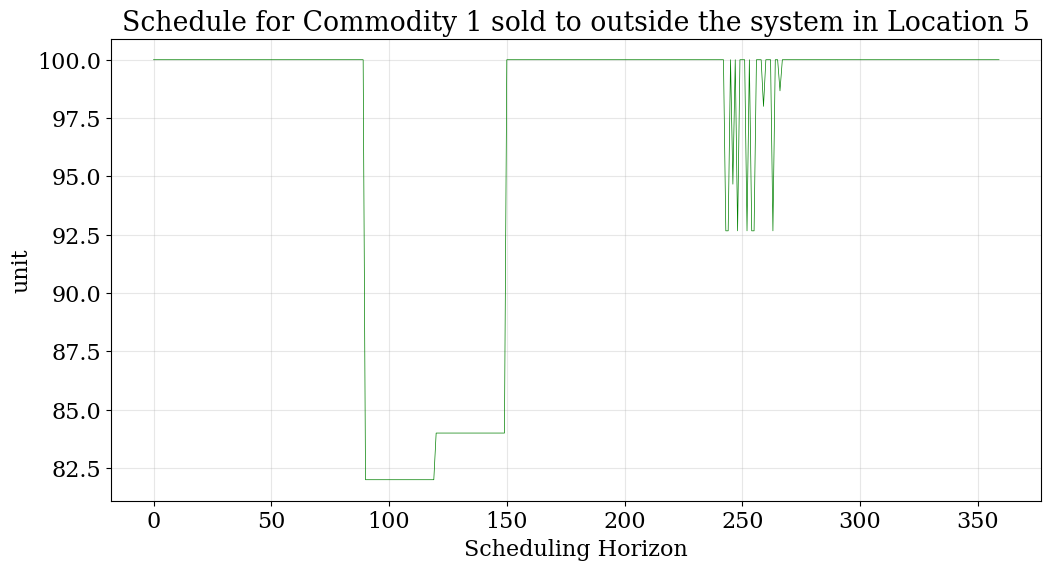

In [119]:
plot_results.schedule(results=results_mincost_6, y_axis='S', component='com1_sold', location='loc5', color='green')

In [120]:
min(value for key, value in results_mincost_6.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold')

82.0

In [121]:
problem_mincost_6.Capex_network.pprint()
problem_mincost_6.Fopex_network.pprint()
problem_mincost_6.Vopex_network.pprint()
problem_mincost_6.Capex_transport_network.pprint()
problem_mincost_6.Fopex_transport_network.pprint()
problem_mincost_6.Vopex_transport_network.pprint()

Capex_network : Capex at network scale
    Size=1, Index=scales_network
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
      0 :     0 : 198.88538888888874 :  None : False : False : NonNegativeReals
Fopex_network : Fixed Opex at network scale
    Size=1, Index=scales_network
    Key : Lower : Value             : Upper : Fixed : Stale : Domain
      0 :     0 : 1.107611111111111 :  None : False : False : NonNegativeReals
Vopex_network : Variable Opex at network scale
    Size=1, Index=scales_network
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
      0 :     0 : 4059.3199999999993 :  None : False : False : NonNegativeReals
Capex_transport_network : overall capex for transport at the network level
    Size=1, Index=scales_network
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
      0 :     0 : 152018.66666666666 :  None : False : False : NonNegativeReals
Fopex_transport_network : overall fopex for transport at the netw

In [122]:
# problem_mincost_7 = formulate(scenario=scenario_disruption,
#                               constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
#                                            Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND},
#                               demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)
# 
# min_demand_satisfaction_7 = levels[7]
# min_demand_dict_7 = {i: {com1_sold: min_demand_satisfaction_7} if i == loc5 else {com1_sold: 0} for i in locset}
# 
# min_demand_7 = min_demand_dict_7
# if isinstance(min_demand_7, dict):
#     if isinstance(list(min_demand_7.keys())[0], Location):
#         try:
#             min_demand_7 = {i.name: {
#                 j.name: min_demand_7[i][j] for j in min_demand_7[i].keys()} for i in min_demand_7.keys()}
#         except:
#             pass
# 
# problem_mincost_7.del_component(constraint_demand2)
# problem_mincost_7.constraint_demand2 = constraint_demand2(instance=problem_mincost_7, demand=min_demand_7,
#                                                           demand_factor=scenario_disruption.demand_factor,
#                                                           demand_scale_level=scenario_disruption.demand_scale_level,
#                                                           scheduling_scale_level=scenario_disruption.scheduling_scale_level,
#                                                           cluster_wt=None, loc_res_dict=None, sign='geq')
# 
# results_mincost_7 = solve(scenario=scenario_disruption, instance=problem_mincost_7, solver='gurobi', name='MILP')

In [123]:
# plot_results.schedule(results=results_mincost_7, y_axis='S', component='com1_sold', location='loc5', color='green')

In [124]:
# min(value for key, value in results_mincost_7.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold')

In [125]:
# problem_mincost_7.Capex_network.pprint()
# problem_mincost_7.Fopex_network.pprint()
# problem_mincost_7.Vopex_network.pprint()
# problem_mincost_7.Capex_transport_network.pprint()
# problem_mincost_7.Fopex_transport_network.pprint()
# problem_mincost_7.Vopex_transport_network.pprint()

In [126]:
# plot_results.cost(results=results_mincost, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc4')

In [127]:
# plot_results.cost(results=results_mincost_6, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc4')

In [128]:
# import matplotlib.pyplot as plt
# from matplotlib import rc
# 
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
# rc('text', usetex=False)
# 
# fig, ax = plt.subplots()
# 
# # Plot data from the first dataset
# ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'), label='Location 4', color='blue')
# 
# # ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'), label='Location 6', color='green')
# # 
# # ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'), label='Location 7', color='red')
# 
# # Plot data from the second dataset
# # ax.plot(range(len(scenario_disruption.availability_factor['loc6']['com1_pur'])), list(scenario_disruption.availability_factor['loc6']['com1_pur'].values()), label='Location 6', color='red', marker='x')
# 
# # Customize the plot
# ax.set_xlabel('Time Horizon')
# ax.set_ylabel('Inventory level')
# ax.set_title('Inventory levels for Commodity 1')
# ax.legend()
# ax.plot(linewidth=0.5)
# plt.grid(alpha=0.3)
# plt.rcdefaults()
# # Show the plot
# plt.show()

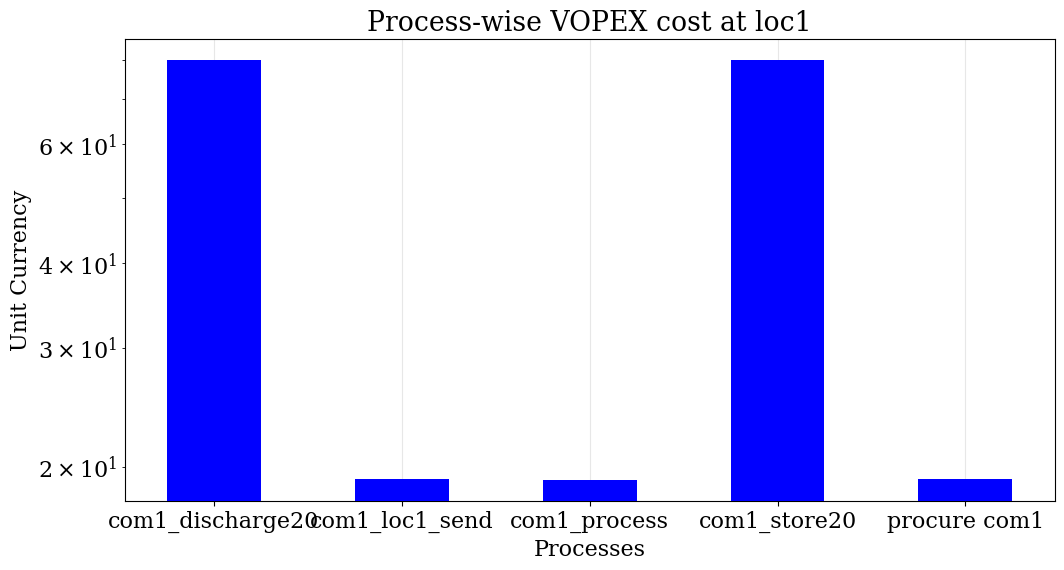

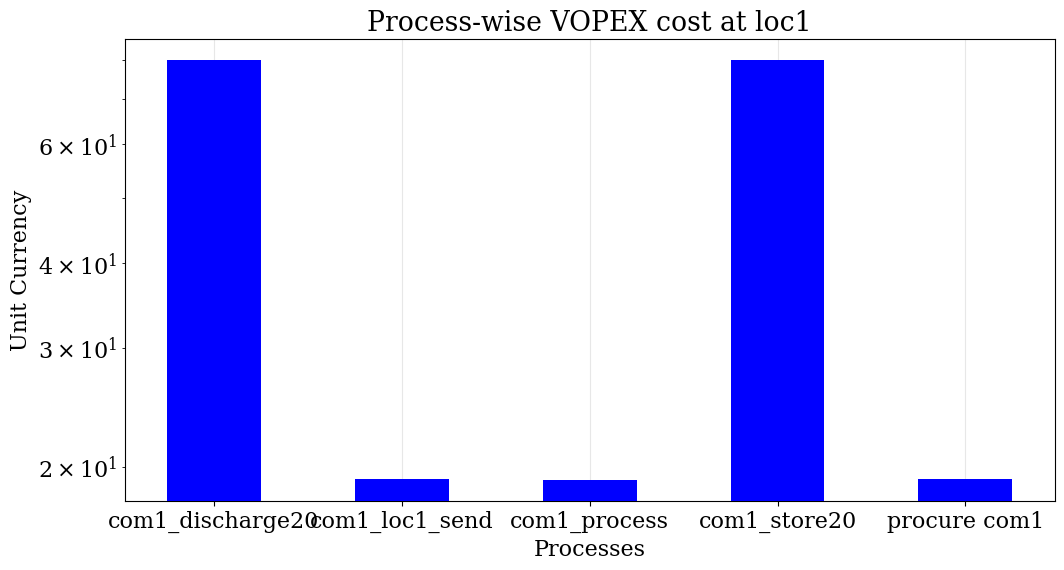

In [129]:
# plot_results.cost(results=results_mincost, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc1')
# plot_results.cost(results=results_mincost_6, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc1')

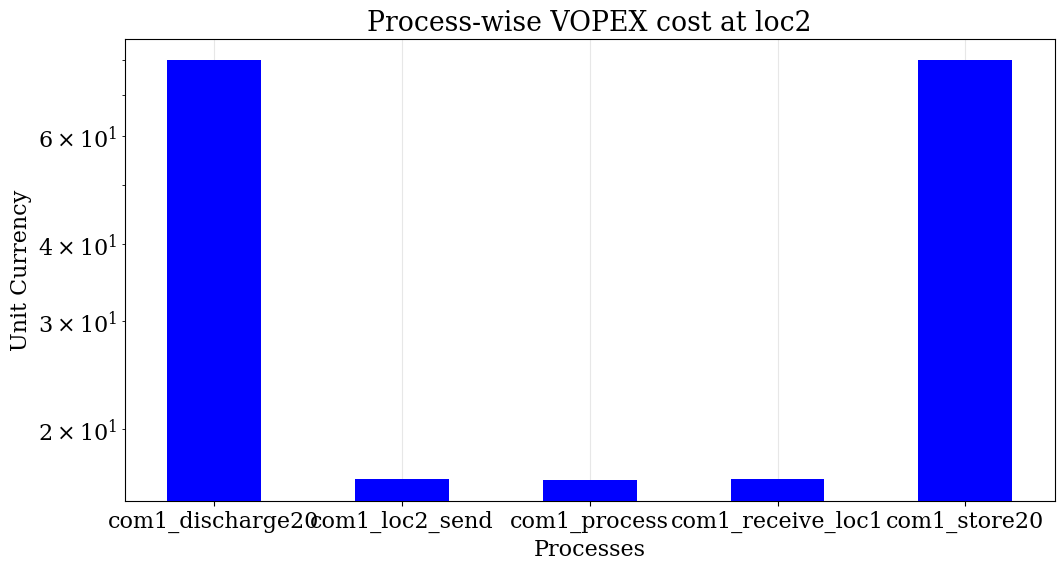

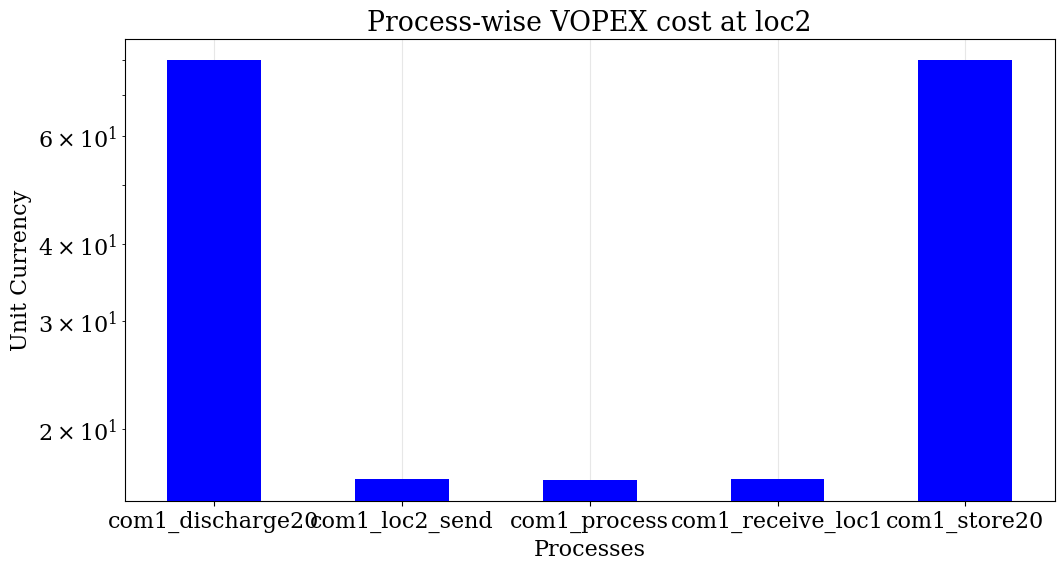

In [130]:
# plot_results.cost(results=results_mincost, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc2')
# plot_results.cost(results=results_mincost_6, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc2')

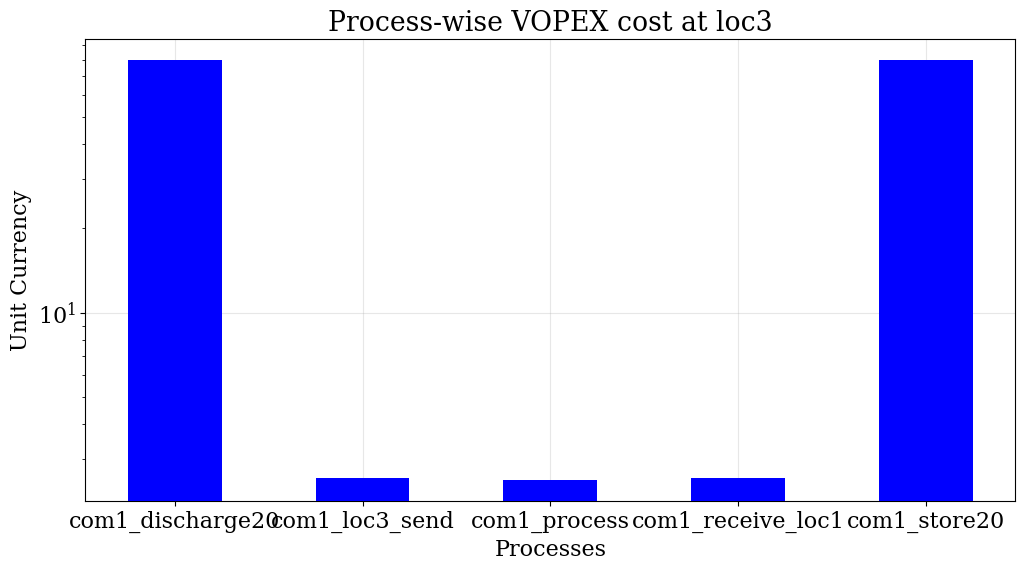

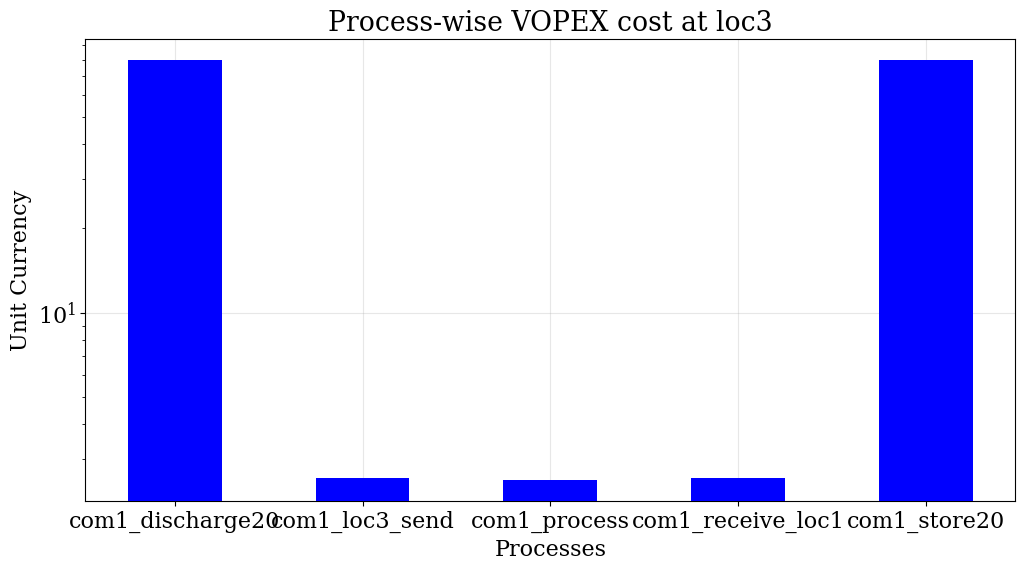

In [131]:
# plot_results.cost(results=results_mincost, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc3')
# plot_results.cost(results=results_mincost_6, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc3')

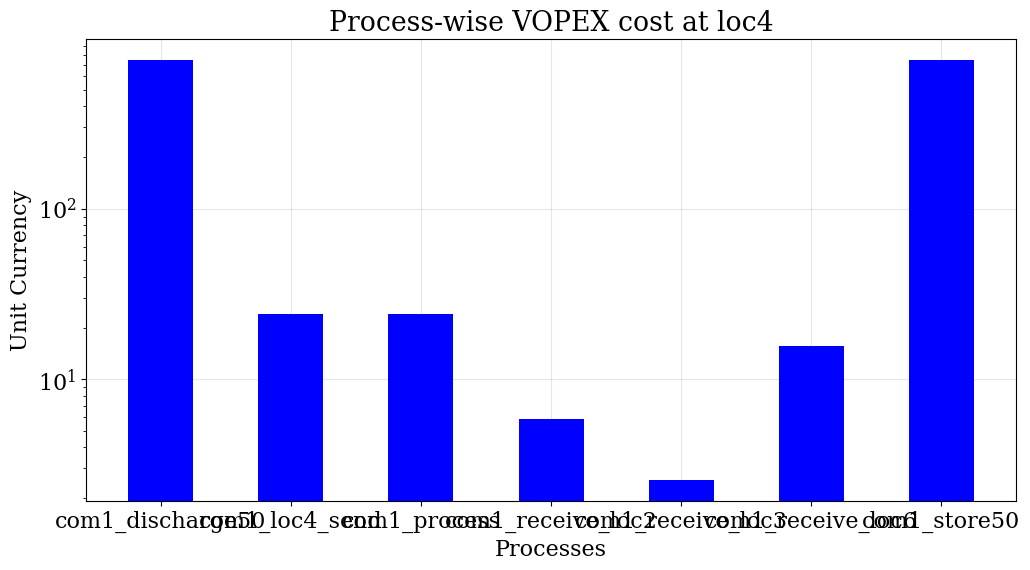

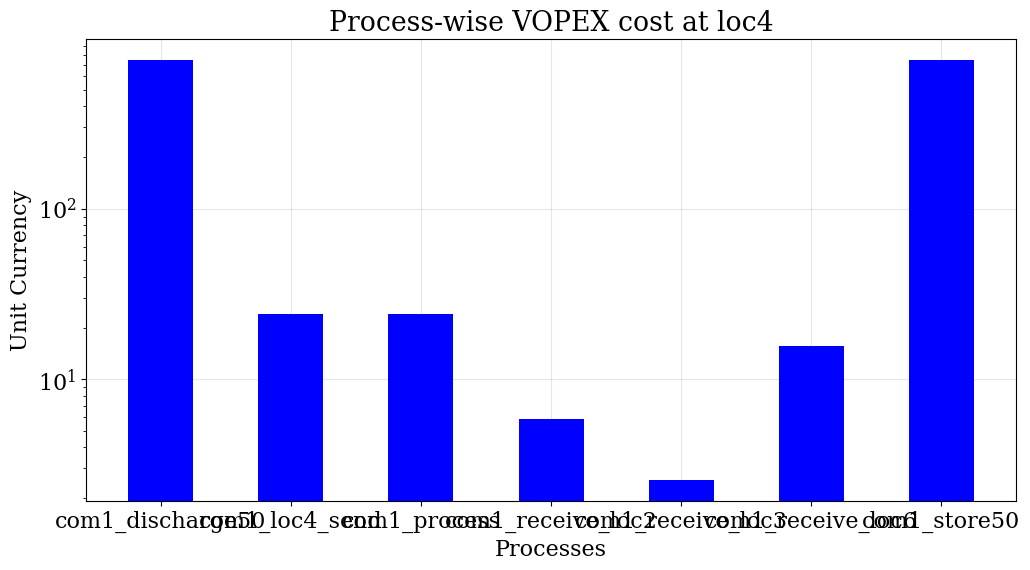

In [132]:
# plot_results.cost(results=results_mincost, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc4')
# plot_results.cost(results=results_mincost_6, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc4')

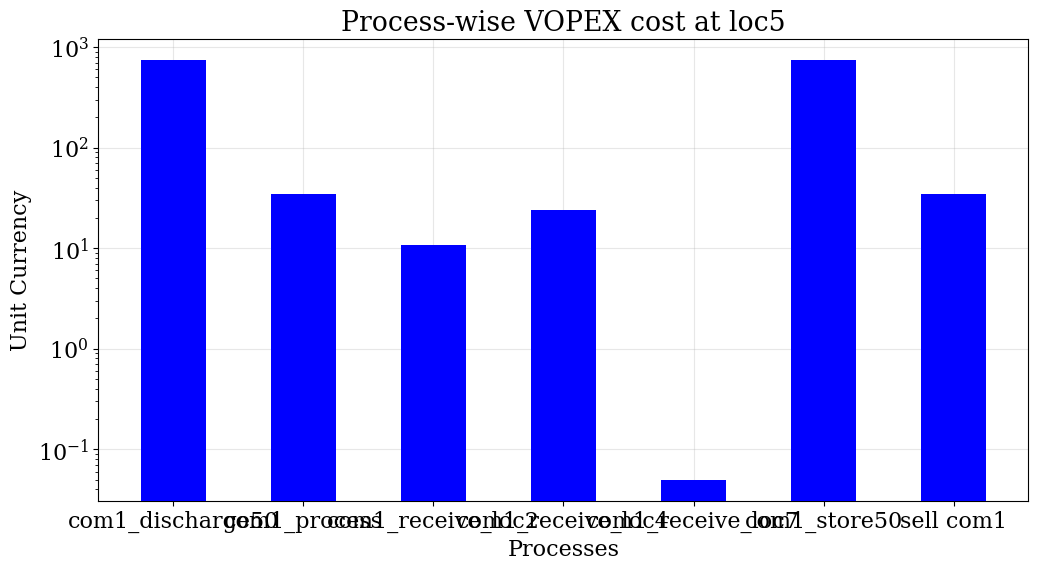

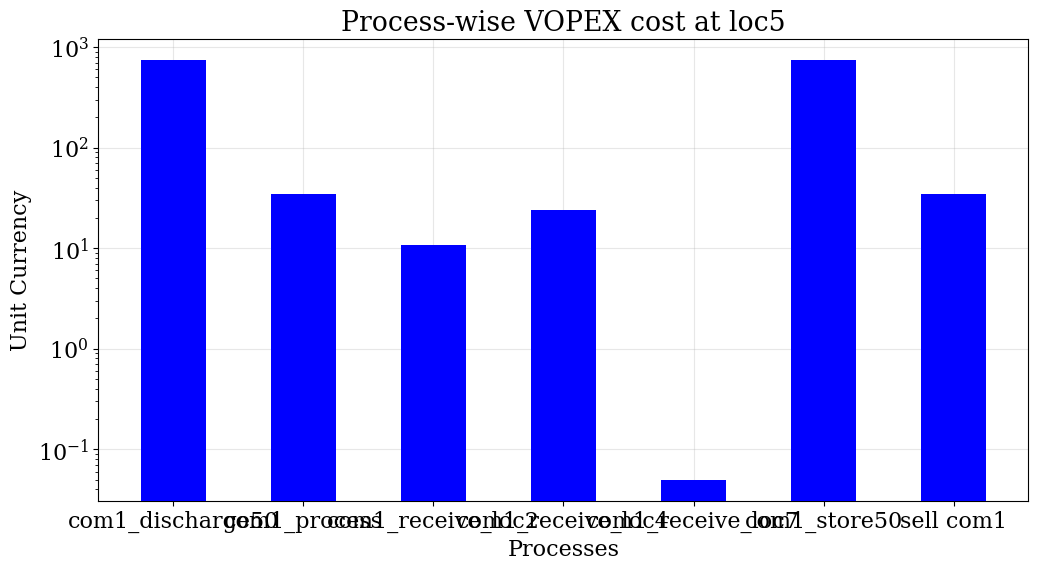

In [133]:
# plot_results.cost(results=results_mincost, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc5')
# plot_results.cost(results=results_mincost_6, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc5')

In [138]:
# sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[0]=='loc5' and key[1]=='com1_sold')

1079.9999999999995

In [139]:
# sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[0]=='loc5' and key[1]=='com1_sold')

1079.9999999999995

In [142]:
# print([(key, value) for key, value in results_mincost.output['Demand_penalty'].items() if key[0]=='loc5' and key[1]=='com1_sold' and value!=0])

[(('loc5', 'com1_sold', 0, 3, 0), 19.33333333333333), (('loc5', 'com1_sold', 0, 3, 1), 23.33333333333333), (('loc5', 'com1_sold', 0, 3, 2), 20.0), (('loc5', 'com1_sold', 0, 3, 3), 24.0), (('loc5', 'com1_sold', 0, 3, 4), 2.0), (('loc5', 'com1_sold', 0, 3, 5), 23.33333333333333), (('loc5', 'com1_sold', 0, 3, 6), 23.33333333333333), (('loc5', 'com1_sold', 0, 3, 7), 24.0), (('loc5', 'com1_sold', 0, 3, 8), 19.33333333333333), (('loc5', 'com1_sold', 0, 3, 9), 24.0), (('loc5', 'com1_sold', 0, 3, 10), 24.0), (('loc5', 'com1_sold', 0, 3, 11), 23.33333333333333), (('loc5', 'com1_sold', 0, 3, 12), 23.33333333333333), (('loc5', 'com1_sold', 0, 3, 13), 20.0), (('loc5', 'com1_sold', 0, 3, 14), 19.33333333333333), (('loc5', 'com1_sold', 0, 3, 15), 23.33333333333333), (('loc5', 'com1_sold', 0, 3, 16), 24.0), (('loc5', 'com1_sold', 0, 3, 17), 24.0), (('loc5', 'com1_sold', 0, 3, 18), 19.33333333333333), (('loc5', 'com1_sold', 0, 3, 19), 23.33333333333333), (('loc5', 'com1_sold', 0, 3, 20), 23.3333333333

In [143]:
# problem_mincost.S['loc5','com1_sold',0,3,0].pprint()

{Member of S} : Resource Dispensed/Sold
    Size=2520, Index=S_index
    Key                            : Lower : Value             : Upper : Fixed : Stale : Domain
    ('loc5', 'com1_sold', 0, 3, 0) :     0 : 80.66666666666667 :  None : False :  True : NonNegativeReals


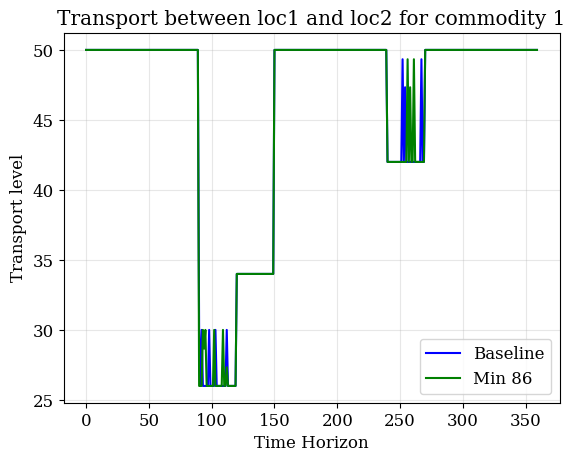

In [144]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc2'and key[2]=='truck50_12'and key[3]=='com1_loc1_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc2'and key[2]=='truck50_12'and key[3]=='com1_loc1_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc2'and key[2]=='truck50_12'and key[3]=='com1_loc1_out'))), list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc2'and key[2]=='truck50_12'and key[3]=='com1_loc1_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc1 and loc2 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

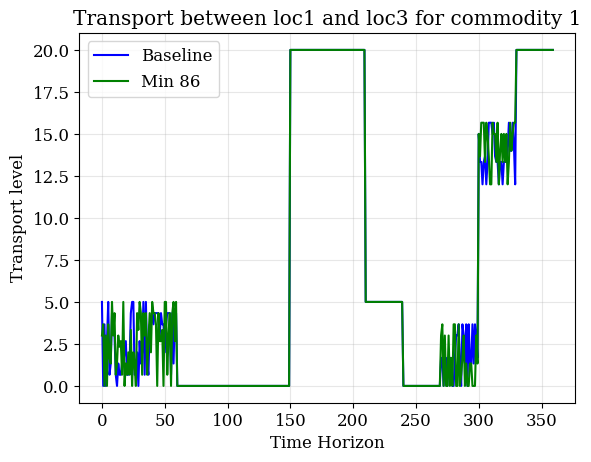

In [146]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc3'and key[2]=='truck30_13'and key[3]=='com1_loc1_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc3'and key[2]=='truck30_13'and key[3]=='com1_loc1_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc3'and key[2]=='truck30_13'and key[3]=='com1_loc1_out'))), list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc3'and key[2]=='truck30_13'and key[3]=='com1_loc1_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc1 and loc3 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

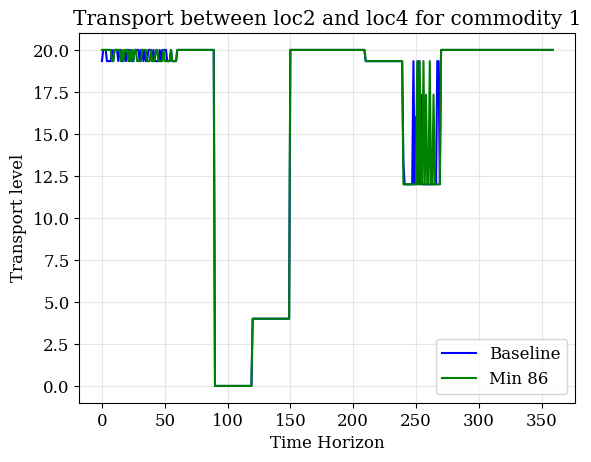

In [147]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc4'and key[2]=='truck50_24'and key[3]=='com1_loc2_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc4'and key[2]=='truck50_24'and key[3]=='com1_loc2_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc4'and key[2]=='truck50_24'and key[3]=='com1_loc2_out'))), list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc4'and key[2]=='truck50_24'and key[3]=='com1_loc2_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc2 and loc4 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

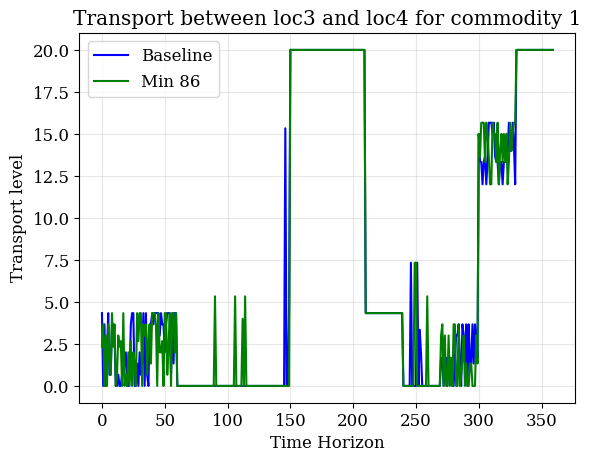

In [148]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc3' and key[1]=='loc4'and key[2]=='truck20_34'and key[3]=='com1_loc3_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc3' and key[1]=='loc4'and key[2]=='truck20_34'and key[3]=='com1_loc3_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc3' and key[1]=='loc4'and key[2]=='truck20_34'and key[3]=='com1_loc3_out'))), list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc3' and key[1]=='loc4'and key[2]=='truck20_34'and key[3]=='com1_loc3_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc3 and loc4 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

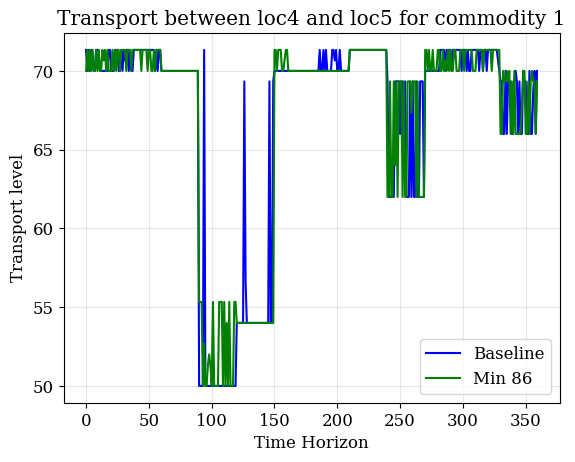

In [149]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'))), list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc4 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

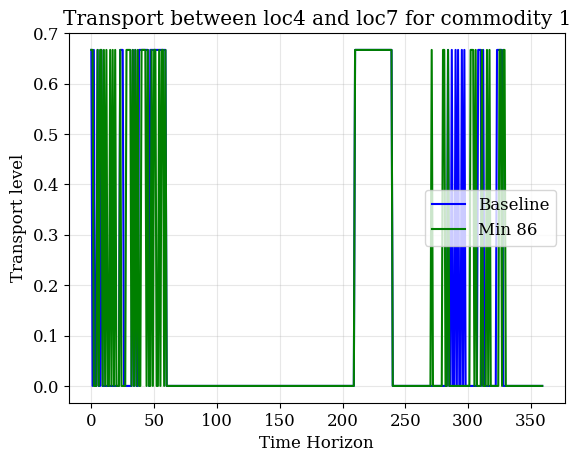

In [150]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'))), list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc4 and loc7 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

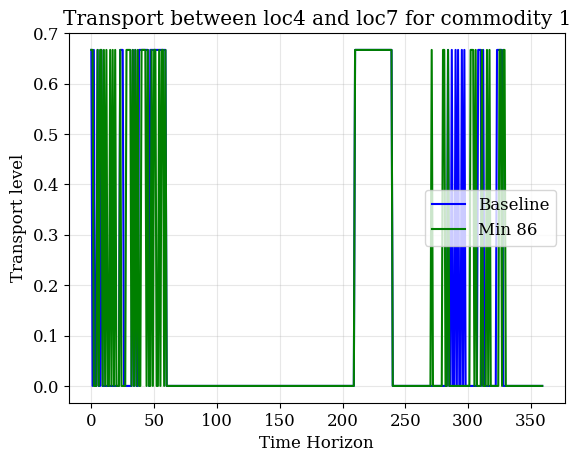

In [151]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'))), list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc4 and loc7 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

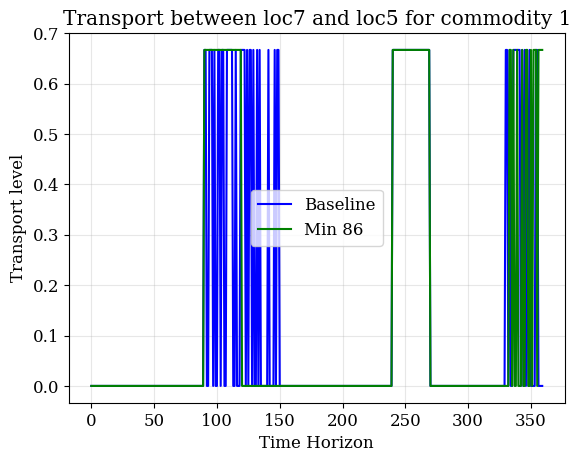

In [152]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'))), list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc7 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

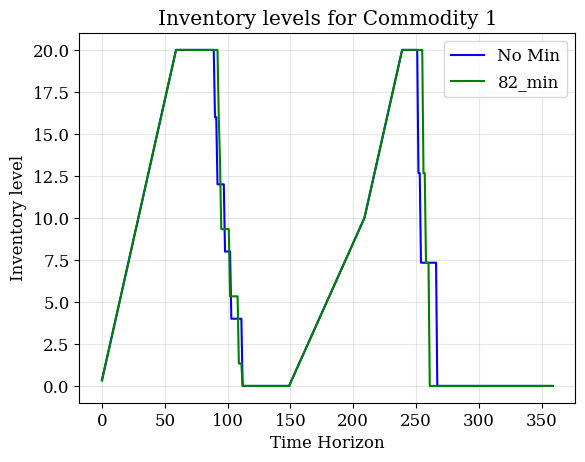

In [155]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_stored20'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost_6.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_stored20'), label='82_min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

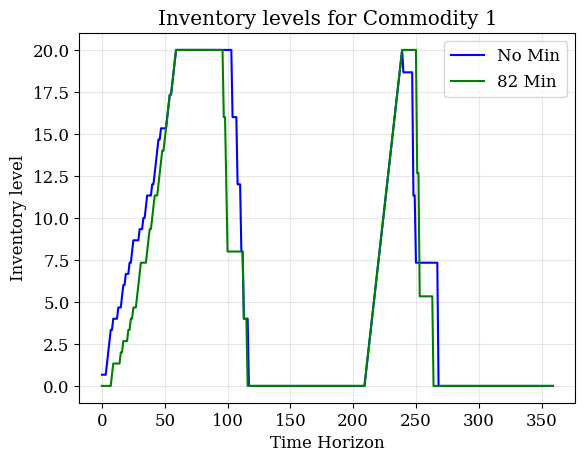

In [157]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost_6.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'), label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()